In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
from torch.utils.data import DataLoader, random_split
from torchmetrics import Accuracy, F1Score, ConfusionMatrix, AUROC
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

dataset_size = len(dataset)
train_size = int(0.80 * dataset_size)
val_size = dataset_size - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

cuda
Files already downloaded and verified
Files already downloaded and verified


Files already downloaded and verified


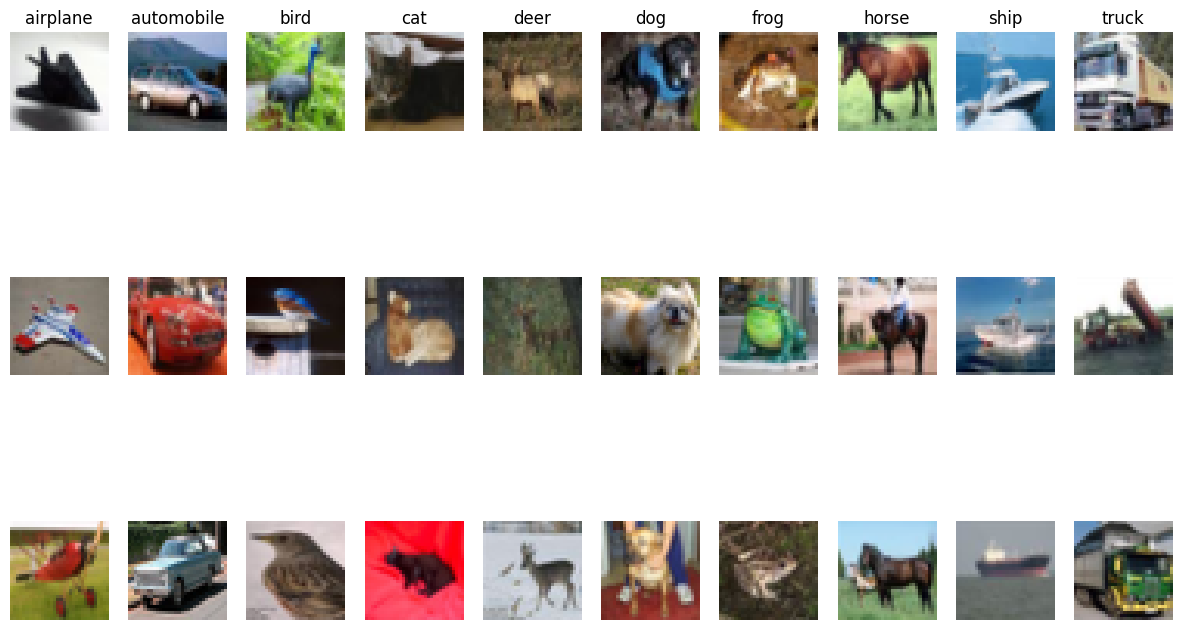

In [3]:
def show_multiple_images_per_class(dataset, classes, num_images=3):
    class_images = {i: [] for i in range(len(classes))}

    for img, label in dataset:
        if len(class_images[label]) < num_images:
            class_images[label].append(img)
        if all(len(class_images[i]) >= num_images for i in range(len(classes))):
            break

    fig, axes = plt.subplots(num_images, len(classes), figsize=(15, 3*num_images))
    for i, (label, imgs) in enumerate(class_images.items()):
        for j, img in enumerate(imgs):
            img = img.numpy().transpose((1, 2, 0))
            axes[j, i].imshow(img)
            if j == 0:
                axes[j, i].set_title(classes[label])
            axes[j, i].axis('off')

    plt.show()

show_img_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())
classes = show_img_dataset.classes
show_multiple_images_per_class(show_img_dataset, classes, num_images=3)

In [4]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.bn2 = nn.BatchNorm2d(128)
        self.bn3 = nn.BatchNorm2d(256)
        self.bn4 = nn.BatchNorm2d(512)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(512 * 4 * 4, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 10)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        # x = x.view(-1, 512 * 8 * 8)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x


In [5]:
class ResNet(nn.Module):
    def __init__(self):
        super(ResNet, self).__init__()
        self.model = models.resnet50()
        self.model.fc = nn.Linear(self.model.fc.in_features, 10)

    def forward(self, x):
        return self.model(x)

In [6]:
class PretrainedResNet(nn.Module):
    def __init__(self):
        super(PretrainedResNet, self).__init__()
        self.model = models.resnet50(weights = models.ResNet50_Weights.IMAGENET1K_V2)
        self.model.fc = nn.Linear(self.model.fc.in_features, 10)

    def forward(self, x):
        return self.model(x)

In [8]:
class DenseNet(nn.Module):
    def __init__(self):
        super(DenseNet, self).__init__()
        self.model = models.densenet161()
        self.model.classifier = nn.Linear(self.model.classifier.in_features, 10)

    def forward(self, x):
        return self.model(x)

In [9]:
class PretrainedDenseNet(nn.Module):
    def __init__(self):
        super(PretrainedDenseNet, self).__init__()
        self.model = models.densenet161(weights = models.DenseNet161_Weights.IMAGENET1K_V1)
        self.model.classifier = nn.Linear(self.model.classifier.in_features, 10)

    def forward(self, x):
        return self.model(x)

In [7]:
class ViT(nn.Module):
    def __init__(self):
        super(ViT, self).__init__()
        self.model = models.vit_b_32(weights = models.ViT_B_32_Weights.IMAGENET1K_V1)
        self.model.heads = nn.Linear(self.model.hidden_dim, 10)

    def forward(self, x):
        x = F.interpolate(x, size=(224, 224), mode='bilinear', align_corners=False)
        return self.model(x)

In [10]:
class ConvolutionalProjection(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super(ConvolutionalProjection, self).__init__()
        self.conv = nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            bias=False
        )
        self.bn = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        return self.bn(self.conv(x))

class MultiHeadAttention(nn.Module):
    def __init__(self, embed_dim, num_heads, qkv_bias=False, attn_drop=0.0, proj_drop=0.0):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        self.scale = self.head_dim ** -0.5

        self.qkv = nn.Linear(embed_dim, embed_dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(embed_dim, embed_dim)
        self.proj_drop = nn.Dropout(proj_drop)

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, self.head_dim).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]

        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x

class TransformerBlock(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=4.0, qkv_bias=False, attn_drop=0.0, proj_drop=0.0):
        super(TransformerBlock, self).__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = MultiHeadAttention(dim, num_heads, qkv_bias, attn_drop, proj_drop)

        self.norm2 = nn.LayerNorm(dim)
        self.mlp = nn.Sequential(
            nn.Linear(dim, int(dim * mlp_ratio)),
            nn.GELU(),
            nn.Linear(int(dim * mlp_ratio), dim),
            nn.Dropout(proj_drop)
        )

    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x

class CvTStage(nn.Module):
    def __init__(self, in_channels, out_channels, num_heads, num_layers, patch_size=7, stride=4, padding=2, mlp_ratio=4.0):
        super(CvTStage, self).__init__()
        self.proj = ConvolutionalProjection(
            in_channels, out_channels, kernel_size=patch_size, stride=stride, padding=padding
        )
        self.blocks = nn.Sequential(
            *[TransformerBlock(out_channels, num_heads, mlp_ratio) for _ in range(num_layers)]
        )

    def forward(self, x):
        x = self.proj(x)
        B, C, H, W = x.shape
        x = x.flatten(2).transpose(1, 2)  # Flatten to (B, N, C)
        x = self.blocks(x)
        return x.reshape(B, H, W, C).permute(0, 3, 1, 2)  # Reshape back to (B, C, H, W)

class CvT(nn.Module):
    def __init__(
        self,
        in_channels=3,
        num_classes=10,
        embed_dims=[64, 128, 256],
        num_heads=[1, 2, 4],
        num_layers=[1, 2, 3],
        patch_sizes=[3, 3, 3],
        strides=[2, 2, 2],
        paddings=[1, 1, 1],
        mlp_ratios=[4.0, 4.0, 4.0],
    ):
        super(CvT, self).__init__()
        self.stages = nn.Sequential(
            *[
                CvTStage(
                    in_channels if i == 0 else embed_dims[i - 1],
                    embed_dims[i],
                    num_heads[i],
                    num_layers[i],
                    patch_sizes[i],
                    strides[i],
                    paddings[i],
                    mlp_ratios[i],
                )
                for i in range(len(embed_dims))
            ]
        )
        self.head = nn.Linear(embed_dims[-1], num_classes)

    def forward(self, x):
        x = self.stages(x)
        x = x.mean(dim=[2, 3])
        x = self.head(x)
        return x


In [33]:
def train_model(model, train_loader, val_loader, num_epochs=10, lr=0.001):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[6, 10], gamma=0.3)

    train_losses, val_losses, val_accuracies, val_f1_scores = [], [], [], []
    accuracy_metric = Accuracy(task="multiclass", num_classes=10).to(device)
    f1_score_metric = F1Score(task="multiclass", num_classes=10, average="weighted").to(device)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        scheduler.step()
        train_losses.append(running_loss / len(train_loader))

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_accuracy = 0.0
        val_f1_score = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                val_loss += criterion(outputs, labels).item()
                val_accuracy += accuracy_metric(outputs, labels).item()
                val_f1_score += f1_score_metric(outputs, labels).item()
        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(val_accuracy / len(val_loader))
        val_f1_scores.append(val_f1_score / len(val_loader))

        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}, Val Loss: {val_losses[-1]:.4f} Val Accuracy: {val_accuracies[-1]:.4f}, Val F1 Score: {val_f1_scores[-1]:.4f}")

    return train_losses, val_losses, val_accuracies, val_f1_scores


def test_model(model, test_loader):
    model.eval()
    accuracy_metric = Accuracy(task="multiclass", num_classes=10).to(device)
    f1_score_metric = F1Score(task="multiclass", num_classes=10, average="weighted").to(device)
    roc_auc_metric = AUROC(task="multiclass", num_classes=10, average="macro").to(device)
    confusion_matrix_metric = ConfusionMatrix(task="multiclass", num_classes=10).to(device)

    test_accuracy = 0.0
    test_f1_score = 0.0
    test_roc_auc = 0.0
    test_confusion_matrices = None

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            test_accuracy += accuracy_metric(outputs, labels).item()
            test_f1_score += f1_score_metric(outputs, labels).item()
            test_roc_auc += roc_auc_metric(outputs, labels).item()

            if test_confusion_matrices is None:
                test_confusion_matrices = confusion_matrix_metric(outputs, labels)
            else:
                test_confusion_matrices += confusion_matrix_metric(outputs, labels)

    print(f"Test Accuracy: {test_accuracy / len(test_loader):.4f}, Test F1 Score: {test_f1_score / len(test_loader):.4f}, Test ROC AUC: {test_roc_auc / len(test_loader):.4f}")

    plt.figure(figsize=(10, 8))
    cm = test_confusion_matrices.cpu().numpy()
    plt.imshow(cm, interpolation='nearest', cmap='Blues')
    plt.colorbar()
    plt.xticks(ticks=range(10), labels=dataset.classes, rotation=45)
    plt.yticks(ticks=range(10), labels=dataset.classes, rotation=45)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")

    for i in range(len(cm)):
        for j in range(len(cm[i])):
            plt.text(j, i, format(cm[i][j], 'd'), ha="center", va="center", color="black")

    plt.show()

def plot_metrics(all_train_losses, all_val_losses, all_val_accuracies, all_val_f1_scores):
    epochs = range(1, len(all_train_losses) + 1)
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    for model_name, train_losses in all_train_losses.items():
        axes[0, 0].plot(train_losses, label=f"{model_name}")
    axes[0, 0].set_title("Training Loss")
    axes[0, 0].set_xlabel("Epoch")
    axes[0, 0].set_ylabel("Loss")
    axes[0, 0].legend()

    for model_name, val_losses in all_val_losses.items():
        axes[0, 1].plot(val_losses, label=f"{model_name}")
    axes[0, 1].set_title("Validation Loss")
    axes[0, 1].set_xlabel("Epoch")
    axes[0, 1].set_ylabel("Loss")
    axes[0, 1].legend()

    for model_name, val_accuracies in all_val_accuracies.items():
        axes[1, 0].plot(val_accuracies, label=f"{model_name}")
    axes[1, 0].set_title("Validation Accuracy")
    axes[1, 0].set_xlabel("Epoch")
    axes[1, 0].set_ylabel("Accuracy")
    axes[1, 0].legend()

    for model_name, val_f1_scores in all_val_f1_scores.items():
        axes[1, 1].plot(val_f1_scores, label=f"{model_name}")
    axes[1, 1].set_title("Validation F1 Score")
    axes[1, 1].set_xlabel("Epoch")
    axes[1, 1].set_ylabel("F1 Score")
    axes[1, 1].legend()

    plt.tight_layout()
    plt.show()

Training CNN
Epoch [1/15], Loss: 1.3421, Val Loss: 1.0743 Val Accuracy: 0.6193, Val F1 Score: 0.6180
Epoch [2/15], Loss: 0.8887, Val Loss: 0.7965 Val Accuracy: 0.7231, Val F1 Score: 0.7208
Epoch [3/15], Loss: 0.6962, Val Loss: 0.7094 Val Accuracy: 0.7549, Val F1 Score: 0.7492
Epoch [4/15], Loss: 0.5644, Val Loss: 0.7064 Val Accuracy: 0.7675, Val F1 Score: 0.7671
Epoch [5/15], Loss: 0.4669, Val Loss: 0.6099 Val Accuracy: 0.8022, Val F1 Score: 0.8015
Epoch [6/15], Loss: 0.3792, Val Loss: 0.5921 Val Accuracy: 0.8110, Val F1 Score: 0.8095
Epoch [7/15], Loss: 0.1826, Val Loss: 0.5661 Val Accuracy: 0.8389, Val F1 Score: 0.8374
Epoch [8/15], Loss: 0.1251, Val Loss: 0.6508 Val Accuracy: 0.8357, Val F1 Score: 0.8341
Epoch [9/15], Loss: 0.0896, Val Loss: 0.6900 Val Accuracy: 0.8390, Val F1 Score: 0.8380
Epoch [10/15], Loss: 0.0632, Val Loss: 0.8863 Val Accuracy: 0.8277, Val F1 Score: 0.8262
Epoch [11/15], Loss: 0.0283, Val Loss: 0.8157 Val Accuracy: 0.8477, Val F1 Score: 0.8462
Epoch [12/15], Lo

C:\Users\nicol\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


Test Accuracy: 0.8371, Test F1 Score: 0.8372, Test ROC AUC: 0.9500


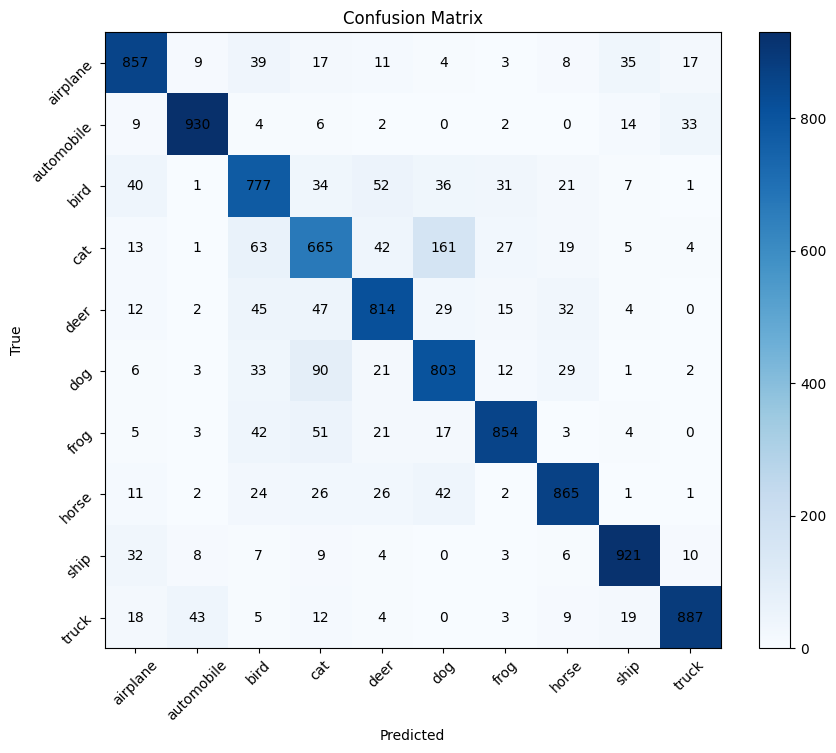

Training ResNet
Epoch [1/15], Loss: 2.0274, Val Loss: 3.0952 Val Accuracy: 0.4247, Val F1 Score: 0.4027
Epoch [2/15], Loss: 1.7661, Val Loss: 1.9750 Val Accuracy: 0.3001, Val F1 Score: 0.2962
Epoch [3/15], Loss: 1.7667, Val Loss: 1.7823 Val Accuracy: 0.4791, Val F1 Score: 0.4627
Epoch [4/15], Loss: 1.5766, Val Loss: 2.4720 Val Accuracy: 0.5144, Val F1 Score: 0.5093
Epoch [5/15], Loss: 1.4317, Val Loss: 1.3401 Val Accuracy: 0.5607, Val F1 Score: 0.5549
Epoch [6/15], Loss: 1.4075, Val Loss: 2.2481 Val Accuracy: 0.5102, Val F1 Score: 0.5049
Epoch [7/15], Loss: 1.1832, Val Loss: 1.3768 Val Accuracy: 0.6098, Val F1 Score: 0.6077
Epoch [8/15], Loss: 1.0856, Val Loss: 1.2809 Val Accuracy: 0.6145, Val F1 Score: 0.6104
Epoch [9/15], Loss: 0.9592, Val Loss: 1.0973 Val Accuracy: 0.6394, Val F1 Score: 0.6372
Epoch [10/15], Loss: 0.8757, Val Loss: 1.0769 Val Accuracy: 0.6577, Val F1 Score: 0.6526
Epoch [11/15], Loss: 0.7070, Val Loss: 0.9719 Val Accuracy: 0.6784, Val F1 Score: 0.6765
Epoch [12/15],

C:\Users\nicol\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


Test Accuracy: 0.6818, Test F1 Score: 0.6797, Test ROC AUC: 0.9151


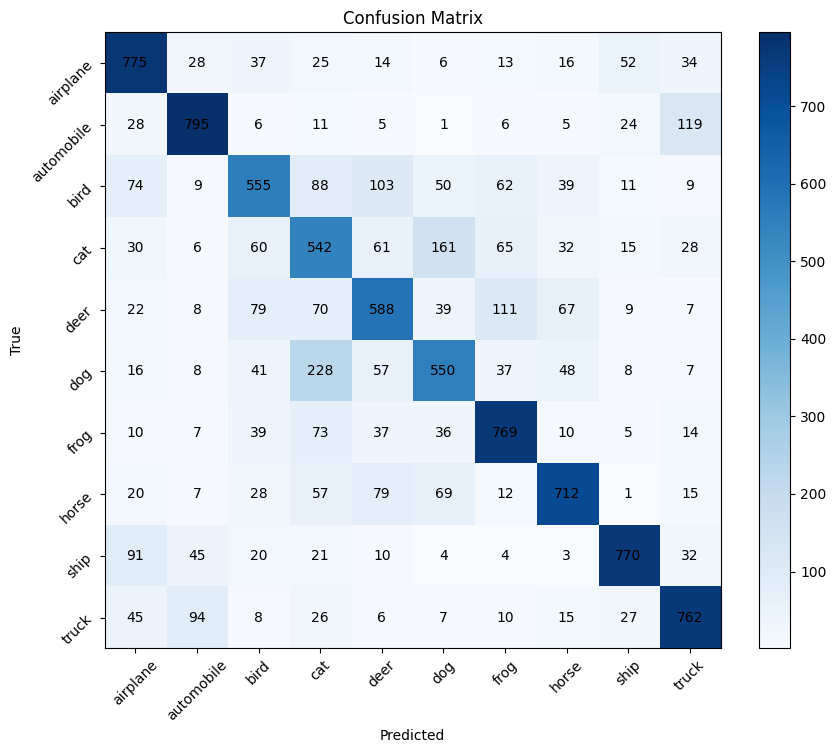

Training PretrainedResNet
Epoch [1/15], Loss: 1.0312, Val Loss: 0.6693 Val Accuracy: 0.7824, Val F1 Score: 0.7781
Epoch [2/15], Loss: 0.6892, Val Loss: 0.6468 Val Accuracy: 0.7847, Val F1 Score: 0.7850
Epoch [3/15], Loss: 0.5609, Val Loss: 0.6884 Val Accuracy: 0.7796, Val F1 Score: 0.7792
Epoch [4/15], Loss: 0.4702, Val Loss: 0.5735 Val Accuracy: 0.8106, Val F1 Score: 0.8093
Epoch [5/15], Loss: 0.4037, Val Loss: 0.5036 Val Accuracy: 0.8350, Val F1 Score: 0.8349
Epoch [6/15], Loss: 0.3339, Val Loss: 0.6408 Val Accuracy: 0.7999, Val F1 Score: 0.8004
Epoch [7/15], Loss: 0.1388, Val Loss: 0.4773 Val Accuracy: 0.8620, Val F1 Score: 0.8608
Epoch [8/15], Loss: 0.0665, Val Loss: 0.5388 Val Accuracy: 0.8625, Val F1 Score: 0.8613
Epoch [9/15], Loss: 0.0464, Val Loss: 0.5935 Val Accuracy: 0.8560, Val F1 Score: 0.8548
Epoch [10/15], Loss: 0.0417, Val Loss: 0.5723 Val Accuracy: 0.8603, Val F1 Score: 0.8593
Epoch [11/15], Loss: 0.0162, Val Loss: 0.5871 Val Accuracy: 0.8670, Val F1 Score: 0.8668
Epoc

C:\Users\nicol\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


Test Accuracy: 0.8617, Test F1 Score: 0.8618, Test ROC AUC: 0.9551


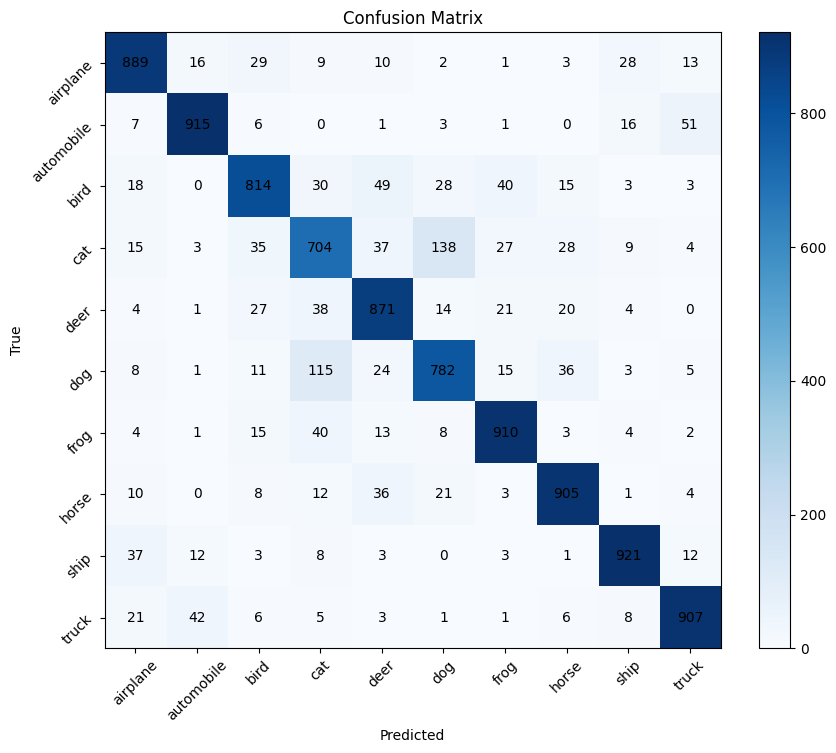

Training DenseNet
Epoch [1/15], Loss: 1.6493, Val Loss: 2.1424 Val Accuracy: 0.4679, Val F1 Score: 0.4608
Epoch [2/15], Loss: 1.3158, Val Loss: 1.0869 Val Accuracy: 0.6125, Val F1 Score: 0.6128
Epoch [3/15], Loss: 1.0240, Val Loss: 0.9171 Val Accuracy: 0.6753, Val F1 Score: 0.6762
Epoch [4/15], Loss: 0.8643, Val Loss: 0.8403 Val Accuracy: 0.7059, Val F1 Score: 0.7023
Epoch [5/15], Loss: 0.7440, Val Loss: 0.7798 Val Accuracy: 0.7290, Val F1 Score: 0.7279
Epoch [6/15], Loss: 0.6396, Val Loss: 0.7507 Val Accuracy: 0.7467, Val F1 Score: 0.7433
Epoch [7/15], Loss: 0.3968, Val Loss: 0.6299 Val Accuracy: 0.7868, Val F1 Score: 0.7857
Epoch [8/15], Loss: 0.2991, Val Loss: 0.6454 Val Accuracy: 0.7946, Val F1 Score: 0.7931
Epoch [9/15], Loss: 0.2208, Val Loss: 0.7148 Val Accuracy: 0.7899, Val F1 Score: 0.7885
Epoch [10/15], Loss: 0.1632, Val Loss: 0.8071 Val Accuracy: 0.7865, Val F1 Score: 0.7853
Epoch [11/15], Loss: 0.0689, Val Loss: 0.8479 Val Accuracy: 0.7999, Val F1 Score: 0.7990
Epoch [12/15

C:\Users\nicol\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


Test Accuracy: 0.7912, Test F1 Score: 0.7921, Test ROC AUC: 0.9434


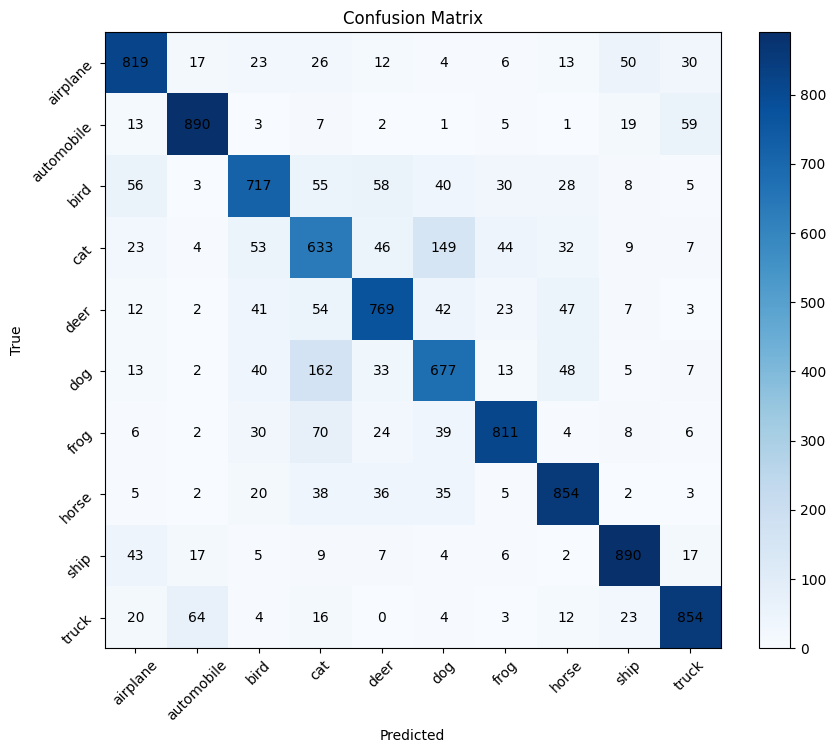

Training PretrainedDenseNet
Epoch [1/15], Loss: 1.3953, Val Loss: 1.0228 Val Accuracy: 0.6345, Val F1 Score: 0.6274
Epoch [2/15], Loss: 0.9489, Val Loss: 0.7579 Val Accuracy: 0.7386, Val F1 Score: 0.7389
Epoch [3/15], Loss: 0.7439, Val Loss: 0.6870 Val Accuracy: 0.7770, Val F1 Score: 0.7742
Epoch [4/15], Loss: 0.5999, Val Loss: 0.6334 Val Accuracy: 0.7805, Val F1 Score: 0.7750
Epoch [5/15], Loss: 0.5205, Val Loss: 0.5908 Val Accuracy: 0.8000, Val F1 Score: 0.7994
Epoch [6/15], Loss: 0.4427, Val Loss: 0.5462 Val Accuracy: 0.8128, Val F1 Score: 0.8091
Epoch [7/15], Loss: 0.2272, Val Loss: 0.4637 Val Accuracy: 0.8504, Val F1 Score: 0.8479
Epoch [8/15], Loss: 0.1439, Val Loss: 0.5101 Val Accuracy: 0.8449, Val F1 Score: 0.8447
Epoch [9/15], Loss: 0.0927, Val Loss: 0.5648 Val Accuracy: 0.8424, Val F1 Score: 0.8420
Epoch [10/15], Loss: 0.0670, Val Loss: 0.5740 Val Accuracy: 0.8436, Val F1 Score: 0.8437
Epoch [11/15], Loss: 0.0273, Val Loss: 0.5741 Val Accuracy: 0.8550, Val F1 Score: 0.8549
Ep

C:\Users\nicol\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


Test Accuracy: 0.8487, Test F1 Score: 0.8484, Test ROC AUC: 0.9541


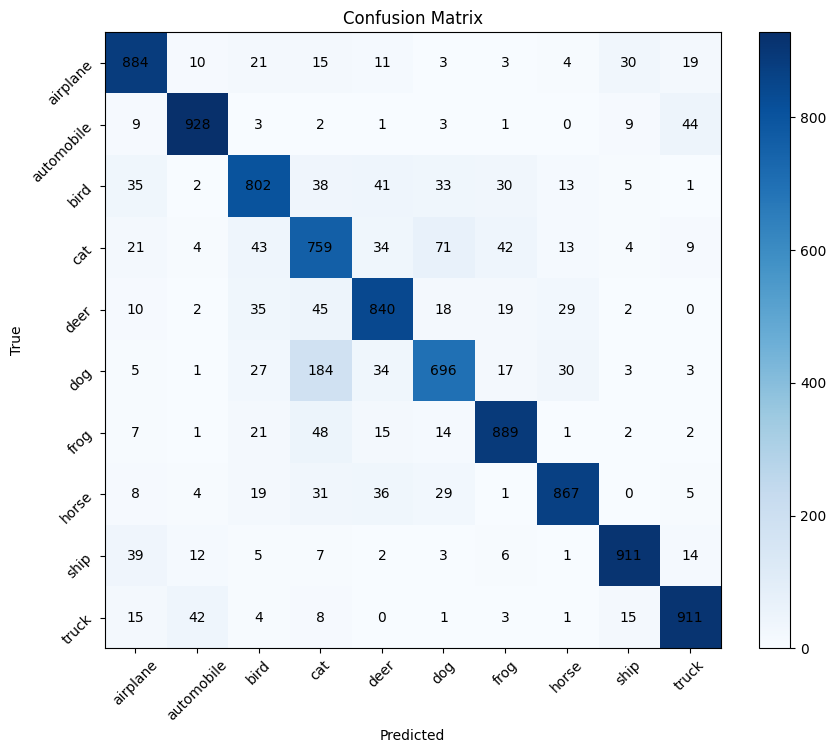

Training CvT
Epoch [1/15], Loss: 1.7335, Val Loss: 1.6995 Val Accuracy: 0.3995, Val F1 Score: 0.3927
Epoch [2/15], Loss: 1.4902, Val Loss: 1.3595 Val Accuracy: 0.4947, Val F1 Score: 0.4810
Epoch [3/15], Loss: 1.3994, Val Loss: 1.4705 Val Accuracy: 0.4608, Val F1 Score: 0.4464
Epoch [4/15], Loss: 1.3727, Val Loss: 1.3372 Val Accuracy: 0.5178, Val F1 Score: 0.4975
Epoch [5/15], Loss: 1.2637, Val Loss: 1.4103 Val Accuracy: 0.4877, Val F1 Score: 0.4715
Epoch [6/15], Loss: 1.2223, Val Loss: 1.2179 Val Accuracy: 0.5495, Val F1 Score: 0.5399
Epoch [7/15], Loss: 1.0165, Val Loss: 1.0386 Val Accuracy: 0.6234, Val F1 Score: 0.6165
Epoch [8/15], Loss: 0.9401, Val Loss: 0.9621 Val Accuracy: 0.6485, Val F1 Score: 0.6488
Epoch [9/15], Loss: 0.8925, Val Loss: 0.9389 Val Accuracy: 0.6583, Val F1 Score: 0.6555
Epoch [10/15], Loss: 0.8450, Val Loss: 0.9065 Val Accuracy: 0.6750, Val F1 Score: 0.6712
Epoch [11/15], Loss: 0.7367, Val Loss: 0.8716 Val Accuracy: 0.6919, Val F1 Score: 0.6927
Epoch [12/15], Lo

C:\Users\nicol\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


Test Accuracy: 0.6870, Test F1 Score: 0.6859, Test ROC AUC: 0.9213


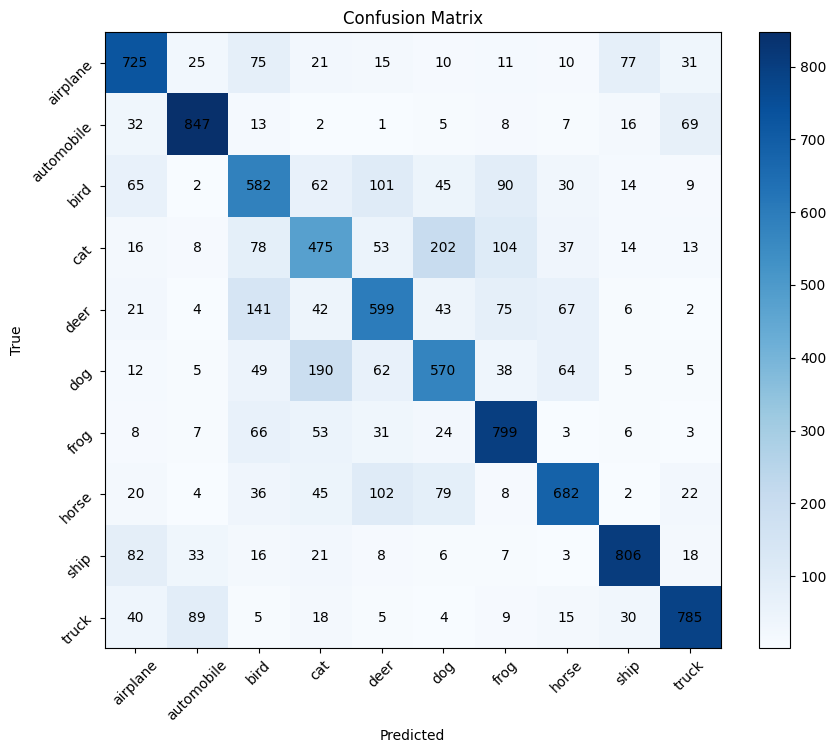

Training ViT
Epoch [1/15], Loss: 1.8097, Val Loss: 1.6475 Val Accuracy: 0.3850, Val F1 Score: 0.3500
Epoch [2/15], Loss: 1.5401, Val Loss: 1.4455 Val Accuracy: 0.4761, Val F1 Score: 0.4731
Epoch [3/15], Loss: 1.4227, Val Loss: 1.4226 Val Accuracy: 0.4816, Val F1 Score: 0.4720
Epoch [4/15], Loss: 1.3456, Val Loss: 1.3273 Val Accuracy: 0.5165, Val F1 Score: 0.5067
Epoch [5/15], Loss: 1.2802, Val Loss: 1.2853 Val Accuracy: 0.5393, Val F1 Score: 0.5348
Epoch [6/15], Loss: 1.2307, Val Loss: 1.3016 Val Accuracy: 0.5398, Val F1 Score: 0.5295
Epoch [7/15], Loss: 1.0373, Val Loss: 1.1930 Val Accuracy: 0.5768, Val F1 Score: 0.5779
Epoch [8/15], Loss: 0.9439, Val Loss: 1.1883 Val Accuracy: 0.5874, Val F1 Score: 0.5847
Epoch [9/15], Loss: 0.8681, Val Loss: 1.1967 Val Accuracy: 0.5900, Val F1 Score: 0.5896
Epoch [10/15], Loss: 0.7925, Val Loss: 1.2480 Val Accuracy: 0.5831, Val F1 Score: 0.5795
Epoch [11/15], Loss: 0.5968, Val Loss: 1.3934 Val Accuracy: 0.5832, Val F1 Score: 0.5841
Epoch [12/15], Lo

C:\Users\nicol\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


Test Accuracy: 0.5659, Test F1 Score: 0.5648, Test ROC AUC: 0.8741


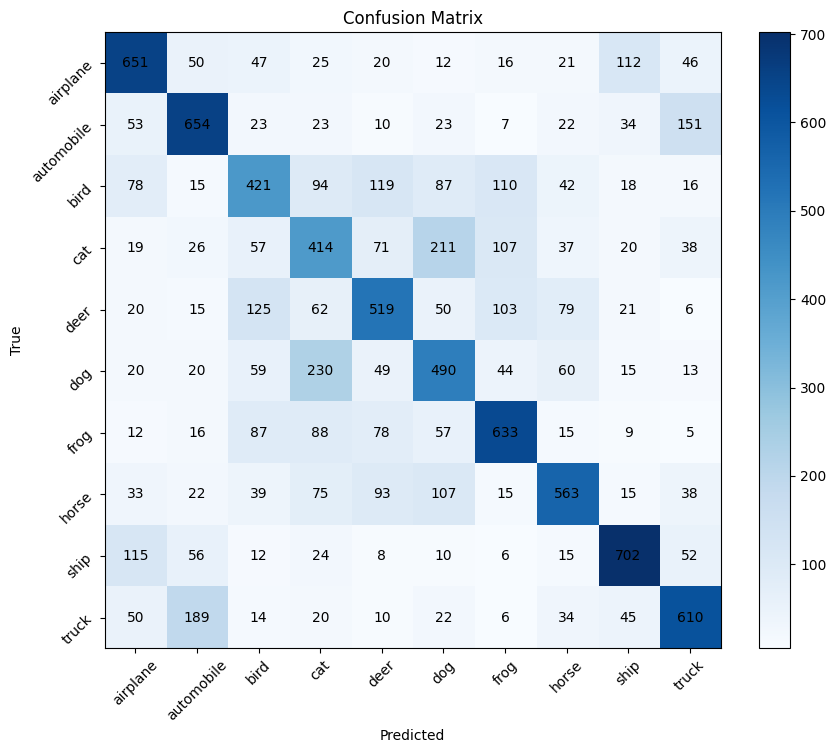

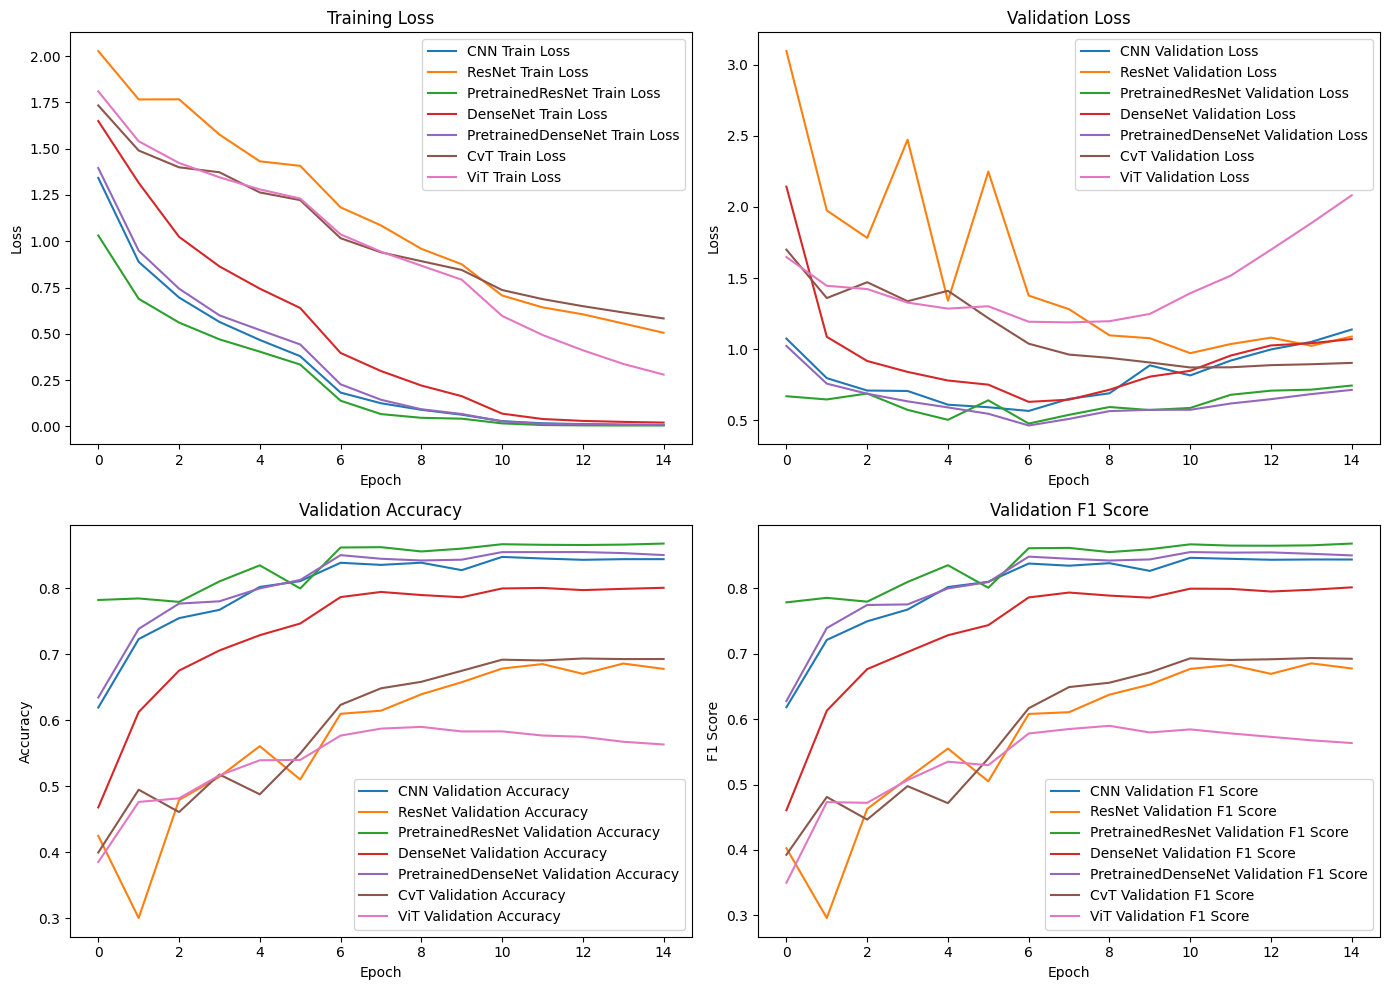

In [20]:
implemented_models = {
    "CNN": CNN,
    "ResNet": ResNet,
    "PretrainedResNet": PretrainedResNet,
    "DenseNet": DenseNet,
    "PretrainedDenseNet": PretrainedDenseNet,
    "CvT": CvT,
    "ViT": ViT,
}

all_train_losses, all_val_losses, all_val_accuracies, all_val_f1_scores = {}, {}, {}, {}
for model_name, model_class in implemented_models.items():
    print(f"Training {model_name}")
    model = model_class().to(device)
    train_losses, val_losses, val_accuracies, val_f1_scores = train_model(model, train_loader, val_loader, num_epochs=15)
    all_train_losses[model_name] = train_losses
    all_val_losses[model_name] = val_losses
    all_val_accuracies[model_name] = val_accuracies
    all_val_f1_scores[model_name] = val_f1_scores
    print(f"Testing {model_name}")
    test_model(model, test_loader)

plot_metrics(all_train_losses, all_val_losses, all_val_accuracies, all_val_f1_scores)



Training
Epoch [1/20], Loss: 1.8669, Val Accuracy: 0.4352
Epoch [2/20], Loss: 1.6485, Val Accuracy: 0.3607
Epoch [3/20], Loss: 1.5759, Val Accuracy: 0.4897
Epoch [4/20], Loss: 1.4440, Val Accuracy: 0.5431
Epoch [5/20], Loss: 1.3843, Val Accuracy: 0.4960
Epoch [6/20], Loss: 1.2253, Val Accuracy: 0.5504
Epoch [7/20], Loss: 0.9446, Val Accuracy: 0.6279
Epoch [8/20], Loss: 0.8167, Val Accuracy: 0.6284
Epoch [9/20], Loss: 0.7028, Val Accuracy: 0.6330
Epoch [10/20], Loss: 0.5836, Val Accuracy: 0.6388
Epoch [11/20], Loss: 0.4623, Val Accuracy: 0.6453
Epoch [12/20], Loss: 0.3999, Val Accuracy: 0.6404
Epoch [13/20], Loss: 0.2984, Val Accuracy: 0.6473
Epoch [14/20], Loss: 0.2518, Val Accuracy: 0.6401
Epoch [15/20], Loss: 0.0857, Val Accuracy: 0.6652
Epoch [16/20], Loss: 0.0384, Val Accuracy: 0.6666
Epoch [17/20], Loss: 0.0289, Val Accuracy: 0.6611
Epoch [18/20], Loss: 0.0299, Val Accuracy: 0.6634
Epoch [19/20], Loss: 0.0288, Val Accuracy: 0.6629
Epoch [20/20], Loss: 0.0337, Val Accuracy: 0.6520

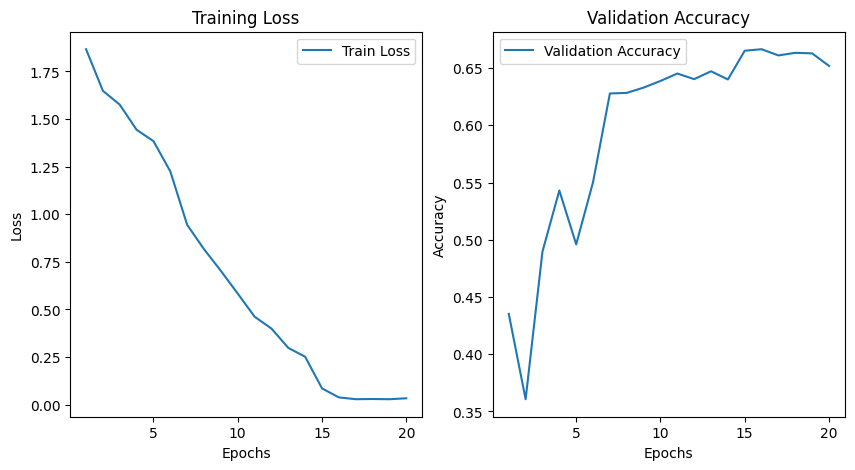


Testing
Test Accuracy: 0.6481


In [41]:
model = ResNet()

print(f"\nTraining")
model = model.to(device)
train_losses, val_losses, val_accuracies, val_f1_scores = train_model(model, train_loader, val_loader, num_epochs=15)
plot_metrics(train_losses, val_losses, val_accuracies, val_f1_scores)
print(f"\nTesting")
test_model(model, test_loader)


Training
Epoch [1/20], Loss: 0.8533, Val Accuracy: 0.7934
Epoch [2/20], Loss: 0.4699, Val Accuracy: 0.8344
Epoch [3/20], Loss: 0.3505, Val Accuracy: 0.8345
Epoch [4/20], Loss: 0.2684, Val Accuracy: 0.8385
Epoch [5/20], Loss: 0.2044, Val Accuracy: 0.8347
Epoch [6/20], Loss: 0.1607, Val Accuracy: 0.8517
Epoch [7/20], Loss: 0.0536, Val Accuracy: 0.8780
Epoch [8/20], Loss: 0.0138, Val Accuracy: 0.8806
Epoch [9/20], Loss: 0.0080, Val Accuracy: 0.8767
Epoch [10/20], Loss: 0.0107, Val Accuracy: 0.8756
Epoch [11/20], Loss: 0.0112, Val Accuracy: 0.8739
Epoch [12/20], Loss: 0.0161, Val Accuracy: 0.8734
Epoch [13/20], Loss: 0.0186, Val Accuracy: 0.8708
Epoch [14/20], Loss: 0.0189, Val Accuracy: 0.8700
Epoch [15/20], Loss: 0.0072, Val Accuracy: 0.8793
Epoch [16/20], Loss: 0.0024, Val Accuracy: 0.8814
Epoch [17/20], Loss: 0.0011, Val Accuracy: 0.8808
Epoch [18/20], Loss: 0.0006, Val Accuracy: 0.8808
Epoch [19/20], Loss: 0.0008, Val Accuracy: 0.8819
Epoch [20/20], Loss: 0.0007, Val Accuracy: 0.8830

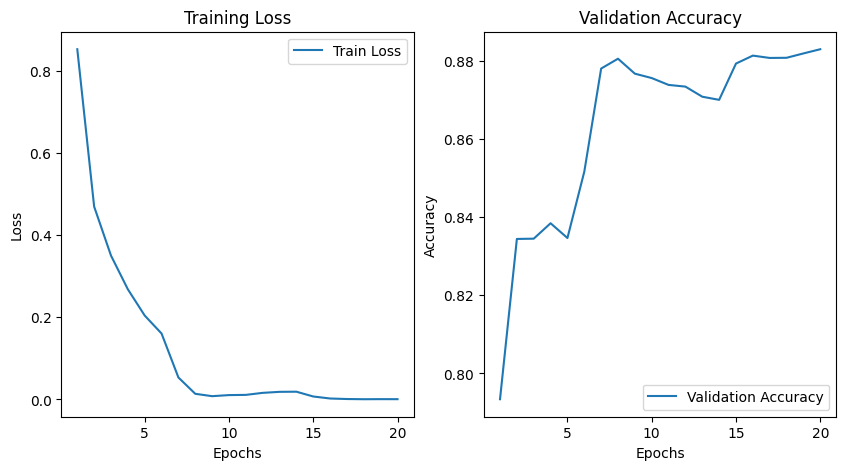


Testing
Test Accuracy: 0.8711


In [43]:
model = PretrainedResNet()

print(f"\nTraining")
model = model.to(device)
train_losses, val_accuracies, val_f1_scores = train_model(model, train_loader, val_loader, num_epochs=15)
plot_metrics(train_losses, val_accuracies, val_f1_scores)
print(f"\nTesting")
test_model(model, test_loader)


Training
Epoch [1/20], Loss: 1.4456, Val Accuracy: 0.5743
Epoch [2/20], Loss: 1.0476, Val Accuracy: 0.6412
Epoch [3/20], Loss: 0.8750, Val Accuracy: 0.6847
Epoch [4/20], Loss: 0.7201, Val Accuracy: 0.7250
Epoch [5/20], Loss: 0.5849, Val Accuracy: 0.7381
Epoch [6/20], Loss: 0.4794, Val Accuracy: 0.7375
Epoch [7/20], Loss: 0.2214, Val Accuracy: 0.7722
Epoch [8/20], Loss: 0.1113, Val Accuracy: 0.7777
Epoch [9/20], Loss: 0.0732, Val Accuracy: 0.7694
Epoch [10/20], Loss: 0.0580, Val Accuracy: 0.7639
Epoch [11/20], Loss: 0.0489, Val Accuracy: 0.7693
Epoch [12/20], Loss: 0.0427, Val Accuracy: 0.7679
Epoch [13/20], Loss: 0.0406, Val Accuracy: 0.7689
Epoch [14/20], Loss: 0.0399, Val Accuracy: 0.7730
Epoch [15/20], Loss: 0.0100, Val Accuracy: 0.7895
Epoch [16/20], Loss: 0.0026, Val Accuracy: 0.7886
Epoch [17/20], Loss: 0.0015, Val Accuracy: 0.7925
Epoch [18/20], Loss: 0.0012, Val Accuracy: 0.7911
Epoch [19/20], Loss: 0.0009, Val Accuracy: 0.7907
Epoch [20/20], Loss: 0.0007, Val Accuracy: 0.7891

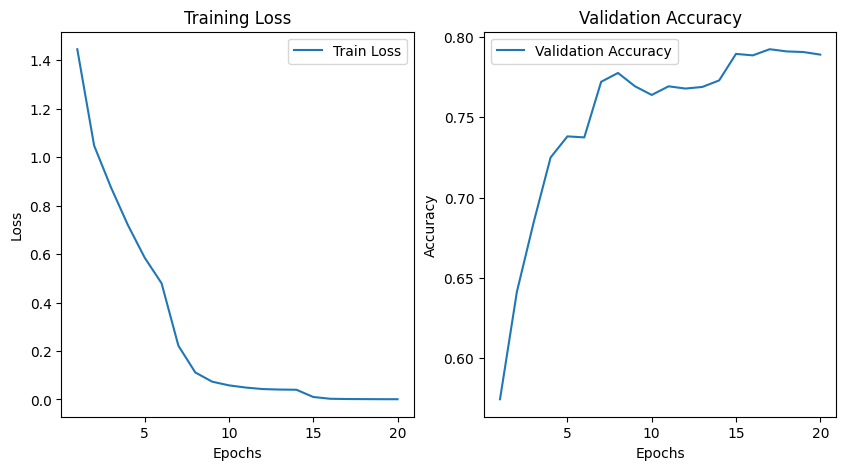


Testing
Test Accuracy: 0.7869


In [44]:
model = DenseNet()

print(f"\nTraining")
model = model.to(device)
train_losses, val_accuracies, val_f1_scores = train_model(model, train_loader, val_loader, num_epochs=15)
plot_metrics(train_losses, val_accuracies, val_f1_scores)
print(f"\nTesting")
test_model(model, test_loader)

Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to C:\Users\nicol/.cache\torch\hub\checkpoints\densenet161-8d451a50.pth
100.0%



Training
Epoch [1/20], Loss: 0.9713, Val Accuracy: 0.7275
Epoch [2/20], Loss: 0.5953, Val Accuracy: 0.7941
Epoch [3/20], Loss: 0.4692, Val Accuracy: 0.8059
Epoch [4/20], Loss: 0.4097, Val Accuracy: 0.8316
Epoch [5/20], Loss: 0.2647, Val Accuracy: 0.8287
Epoch [6/20], Loss: 0.2075, Val Accuracy: 0.8399
Epoch [7/20], Loss: 0.0689, Val Accuracy: 0.8674
Epoch [8/20], Loss: 0.0179, Val Accuracy: 0.8663
Epoch [9/20], Loss: 0.0115, Val Accuracy: 0.8666
Epoch [10/20], Loss: 0.0158, Val Accuracy: 0.8511
Epoch [11/20], Loss: 0.0218, Val Accuracy: 0.8511
Epoch [12/20], Loss: 0.0249, Val Accuracy: 0.8568
Epoch [13/20], Loss: 0.0244, Val Accuracy: 0.8578
Epoch [14/20], Loss: 0.0206, Val Accuracy: 0.8514
Epoch [15/20], Loss: 0.0070, Val Accuracy: 0.8692
Epoch [16/20], Loss: 0.0019, Val Accuracy: 0.8703
Epoch [17/20], Loss: 0.0010, Val Accuracy: 0.8704
Epoch [18/20], Loss: 0.0008, Val Accuracy: 0.8695
Epoch [19/20], Loss: 0.0006, Val Accuracy: 0.8703
Epoch [20/20], Loss: 0.0006, Val Accuracy: 0.8698

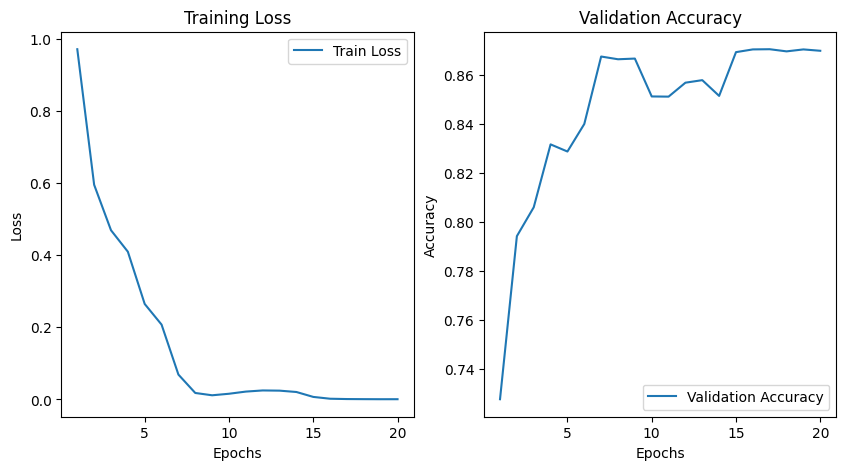


Testing
Test Accuracy: 0.8600


In [45]:
model = PretrainedDenseNet()

print(f"\nTraining")
model = model.to(device)
train_losses, val_accuracies, val_f1_scores = train_model(model, train_loader, val_loader, num_epochs=15)
plot_metrics(train_losses, val_accuracies, val_f1_scores)
print(f"\nTesting")
test_model(model, test_loader)


Training
Epoch [1/20], Loss: 1.6072, Val Accuracy: 0.4936
Epoch [2/20], Loss: 1.2143, Val Accuracy: 0.5441
Epoch [3/20], Loss: 1.0587, Val Accuracy: 0.6015
Epoch [4/20], Loss: 0.9763, Val Accuracy: 0.6402
Epoch [5/20], Loss: 0.9063, Val Accuracy: 0.6613
Epoch [6/20], Loss: 0.8358, Val Accuracy: 0.6771
Epoch [7/20], Loss: 0.6136, Val Accuracy: 0.7313
Epoch [8/20], Loss: 0.5179, Val Accuracy: 0.7322
Epoch [9/20], Loss: 0.4554, Val Accuracy: 0.7402
Epoch [10/20], Loss: 0.3958, Val Accuracy: 0.7343
Epoch [11/20], Loss: 0.3429, Val Accuracy: 0.7329
Epoch [12/20], Loss: 0.2799, Val Accuracy: 0.7284
Epoch [13/20], Loss: 0.2321, Val Accuracy: 0.7369
Epoch [14/20], Loss: 0.1983, Val Accuracy: 0.7295
Epoch [15/20], Loss: 0.0787, Val Accuracy: 0.7493
Epoch [16/20], Loss: 0.0309, Val Accuracy: 0.7493
Epoch [17/20], Loss: 0.0157, Val Accuracy: 0.7506
Epoch [18/20], Loss: 0.0087, Val Accuracy: 0.7492
Epoch [19/20], Loss: 0.0053, Val Accuracy: 0.7490
Epoch [20/20], Loss: 0.0054, Val Accuracy: 0.7447

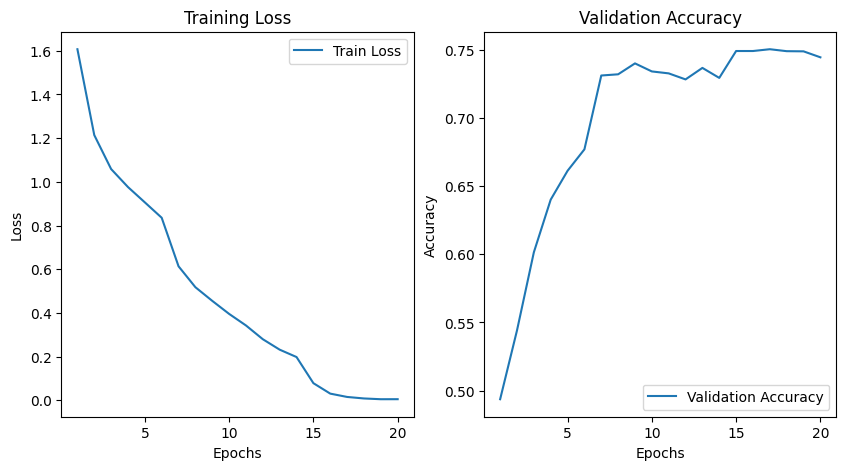


Testing
Test Accuracy: 0.7393


In [46]:
model = CvT()

print(f"\nTraining")
model = model.to(device)
train_losses, val_accuracies, val_f1_scores = train_model(model, train_loader, val_loader, num_epochs=15)
plot_metrics(train_losses, val_accuracies, val_f1_scores)
print(f"\nTesting")
test_model(model, test_loader)

In [47]:
model = ViT()

print(f"\nTraining")
model = model.to(device)
train_losses, val_accuracies, val_f1_scores = train_model(model, train_loader, val_loader, num_epochs=15)
plot_metrics(train_losses, val_accuracies, val_f1_scores)
print(f"\nTesting")
test_model(model, test_loader)


Training
Epoch [1/15], Loss: 1.9202, Val Accuracy: 0.3755
Epoch [2/15], Loss: 1.5984, Val Accuracy: 0.4567
Epoch [3/15], Loss: 1.4470, Val Accuracy: 0.4843
Epoch [4/15], Loss: 1.3475, Val Accuracy: 0.5227
Epoch [5/15], Loss: 1.2791, Val Accuracy: 0.5336
Epoch [6/15], Loss: 1.2165, Val Accuracy: 0.5444
Epoch [7/15], Loss: 1.0171, Val Accuracy: 0.5732
Epoch [8/15], Loss: 0.9287, Val Accuracy: 0.5793
Epoch [9/15], Loss: 0.8508, Val Accuracy: 0.5793
Epoch [10/15], Loss: 0.7807, Val Accuracy: 0.5784
Epoch [11/15], Loss: 0.6977, Val Accuracy: 0.5734


KeyboardInterrupt: 

In [32]:
densenet_model = DenseNet()

print(f"\nTraining")
model = densenet_model.to(device)
train_losses, val_accuracies = train_model(model, train_loader, val_loader, num_epochs=10)
plot_metrics(train_losses, val_accuracies)
print(f"\nTesting")
test_model(model, test_loader)


Training
torch.Size([128, 10])
tensor([[-3.1572,  0.4953, -0.8995,  ..., -3.3248, -0.3393, -1.7342],
        [ 1.5819,  0.3901, -0.9034,  ..., -3.4057,  3.9965,  1.2510],
        [ 3.1164,  1.8135, -1.0980,  ..., -4.0271,  4.5772,  1.8009],
        ...,
        [-1.2406, -2.3041,  0.9901,  ..., -0.9682, -2.7205, -1.0935],
        [-0.6186, -2.0371,  0.5671,  ..., -0.0379, -0.3498, -0.1184],
        [-1.6747, -3.5973,  0.5336,  ..., -0.1096, -1.8029, -2.1451]],
       device='cuda:0')
torch.Size([128])
torch.Size([128, 10])
tensor([[ 1.3711,  4.0281, -0.1044,  ..., -2.6438,  0.8890,  1.6749],
        [ 0.1110,  2.4523, -0.1982,  ..., -2.8467,  1.2709,  1.8525],
        [-2.3604, -3.8513,  0.3621,  ...,  4.9112, -4.6646, -1.7499],
        ...,
        [-0.6551,  0.0907, -0.9321,  ..., -2.8694,  3.1583, -0.1042],
        [-0.8572, -0.8446, -1.2256,  ...,  0.6844,  0.2765,  1.6655],
        [ 0.8252,  2.7015, -1.7573,  ..., -2.9101,  2.9911,  3.4551]],
       device='cuda:0')
torch.Size([

KeyboardInterrupt: 

In [27]:
from einops import rearrange, repeat
from einops.layers.torch import Rearrange
from torch import einsum

class SepConv2d(torch.nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size,
                 stride=1,
                 padding=0,
                 dilation=1,):
        super(SepConv2d, self).__init__()
        self.depthwise = torch.nn.Conv2d(in_channels,
                                         in_channels,
                                         kernel_size=kernel_size,
                                         stride=stride,
                                         padding=padding,
                                         dilation=dilation,
                                         groups=in_channels)
        self.bn = torch.nn.BatchNorm2d(in_channels)
        self.pointwise = torch.nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        x = self.depthwise(x)
        x = self.bn(x)
        x = self.pointwise(x)
        return x

class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(x, **kwargs) + x

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout = 0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.net(x)

class ConvAttention(nn.Module):
    def __init__(self, dim, img_size, heads = 8, dim_head = 64, kernel_size=3, q_stride=1, k_stride=1, v_stride=1, dropout = 0.,
                 last_stage=False):

        super().__init__()
        self.last_stage = last_stage
        self.img_size = img_size
        inner_dim = dim_head *  heads
        project_out = not (heads == 1 and dim_head == dim)

        self.heads = heads
        self.scale = dim_head ** -0.5
        pad = (kernel_size - q_stride)//2
        self.to_q = SepConv2d(dim, inner_dim, kernel_size, q_stride, pad)
        self.to_k = SepConv2d(dim, inner_dim, kernel_size, k_stride, pad)
        self.to_v = SepConv2d(dim, inner_dim, kernel_size, v_stride, pad)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, x):
        b, n, _, h = *x.shape, self.heads
        if self.last_stage:
            cls_token = x[:, 0]
            x = x[:, 1:]
            cls_token = rearrange(cls_token.unsqueeze(1), 'b n (h d) -> b h n d', h = h)
        x = rearrange(x, 'b (l w) n -> b n l w', l=self.img_size, w=self.img_size)
        q = self.to_q(x)
        q = rearrange(q, 'b (h d) l w -> b h (l w) d', h=h)

        v = self.to_v(x)
        v = rearrange(v, 'b (h d) l w -> b h (l w) d', h=h)

        k = self.to_k(x)
        k = rearrange(k, 'b (h d) l w -> b h (l w) d', h=h)

        if self.last_stage:
            q = torch.cat((cls_token, q), dim=2)
            v = torch.cat((cls_token, v), dim=2)
            k = torch.cat((cls_token, k), dim=2)


        dots = einsum('b h i d, b h j d -> b h i j', q, k) * self.scale

        attn = dots.softmax(dim=-1)

        out = einsum('b h i j, b h j d -> b h i d', attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        out =  self.to_out(out)
        return out

class Transformer(nn.Module):
    def __init__(self, dim, img_size, depth, heads, dim_head, mlp_dim, dropout=0., last_stage=False):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                PreNorm(dim, ConvAttention(dim, img_size, heads=heads, dim_head=dim_head, dropout=dropout, last_stage=last_stage)),
                PreNorm(dim, FeedForward(dim, mlp_dim, dropout=dropout))
            ]))

    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return x

class CvT2(nn.Module):
    def __init__(self, image_size, in_channels, num_classes, dim=64, kernels=[7, 3, 3], strides=[4, 2, 2],
                 heads=[1, 3, 6] , depth = [1, 2, 10], pool='cls', dropout=0., emb_dropout=0., scale_dim=4):
        super().__init__()

        assert pool in {'cls', 'mean'}, 'pool type must be either cls (cls token) or mean (mean pooling)'
        self.pool = pool
        self.dim = dim

        ##### Stage 1 #######
        self.stage1_conv_embed = nn.Sequential(
            nn.Conv2d(in_channels, dim, kernels[0], strides[0], 2),
            Rearrange('b c h w -> b (h w) c', h = image_size//4, w = image_size//4),
            nn.LayerNorm(dim)
        )
        self.stage1_transformer = nn.Sequential(
            Transformer(dim=dim, img_size=image_size//4,depth=depth[0], heads=heads[0], dim_head=self.dim,
                                              mlp_dim=dim * scale_dim, dropout=dropout),
            Rearrange('b (h w) c -> b c h w', h = image_size//4, w = image_size//4)
        )

        ##### Stage 2 #######
        in_channels = dim
        scale = heads[1]//heads[0]
        dim = scale*dim
        self.stage2_conv_embed = nn.Sequential(
            nn.Conv2d(in_channels, dim, kernels[1], strides[1], 1),
            Rearrange('b c h w -> b (h w) c', h = image_size//8, w = image_size//8),
            nn.LayerNorm(dim)
        )
        self.stage2_transformer = nn.Sequential(
            Transformer(dim=dim, img_size=image_size//8, depth=depth[1], heads=heads[1], dim_head=self.dim,
                                              mlp_dim=dim * scale_dim, dropout=dropout),
            Rearrange('b (h w) c -> b c h w', h = image_size//8, w = image_size//8)
        )

        ##### Stage 3 #######
        in_channels = dim
        scale = heads[2] // heads[1]
        dim = scale * dim
        self.stage3_conv_embed = nn.Sequential(
            nn.Conv2d(in_channels, dim, kernels[2], strides[2], 1),
            Rearrange('b c h w -> b (h w) c', h = image_size//16, w = image_size//16),
            nn.LayerNorm(dim)
        )
        self.stage3_transformer = nn.Sequential(
            Transformer(dim=dim, img_size=image_size//16, depth=depth[2], heads=heads[2], dim_head=self.dim,
                                              mlp_dim=dim * scale_dim, dropout=dropout, last_stage=True),
        )


        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.dropout_large = nn.Dropout(emb_dropout)


        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )

    def forward(self, img):

        xs = self.stage1_conv_embed(img)
        xs = self.stage1_transformer(xs)

        xs = self.stage2_conv_embed(xs)
        xs = self.stage2_transformer(xs)

        xs = self.stage3_conv_embed(xs)
        b, n, _ = xs.shape
        cls_tokens = repeat(self.cls_token, '() n d -> b n d', b=b)
        xs = torch.cat((cls_tokens, xs), dim=1)
        xs = self.stage3_transformer(xs)
        xs = xs.mean(dim=1) if self.pool == 'mean' else xs[:, 0]

        xs = self.mlp_head(xs)
        return xs


Training
Epoch [1/10], Loss: 2.1650, Val Loss: 2.0745 Val Accuracy: 0.2014, Val F1 Score: 0.1471
Epoch [2/10], Loss: 1.9100, Val Loss: 1.8981 Val Accuracy: 0.3076, Val F1 Score: 0.2753
Epoch [3/10], Loss: 1.7448, Val Loss: 1.7053 Val Accuracy: 0.3631, Val F1 Score: 0.3415
Epoch [4/10], Loss: 1.6278, Val Loss: 1.5888 Val Accuracy: 0.4142, Val F1 Score: 0.4002
Epoch [5/10], Loss: 1.5561, Val Loss: 1.5294 Val Accuracy: 0.4284, Val F1 Score: 0.4003
Epoch [6/10], Loss: 1.4833, Val Loss: 1.4235 Val Accuracy: 0.4773, Val F1 Score: 0.4743
Epoch [7/10], Loss: 1.3590, Val Loss: 1.3553 Val Accuracy: 0.4940, Val F1 Score: 0.4915
Epoch [8/10], Loss: 1.3248, Val Loss: 1.3377 Val Accuracy: 0.4988, Val F1 Score: 0.4952
Epoch [9/10], Loss: 1.2945, Val Loss: 1.3498 Val Accuracy: 0.5018, Val F1 Score: 0.4964
Epoch [10/10], Loss: 1.2823, Val Loss: 1.2952 Val Accuracy: 0.5265, Val F1 Score: 0.5225

Testing


C:\Users\nicol\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


Test Accuracy: 0.5260, Test F1 Score: 0.5194, Test ROC AUC: 0.8706


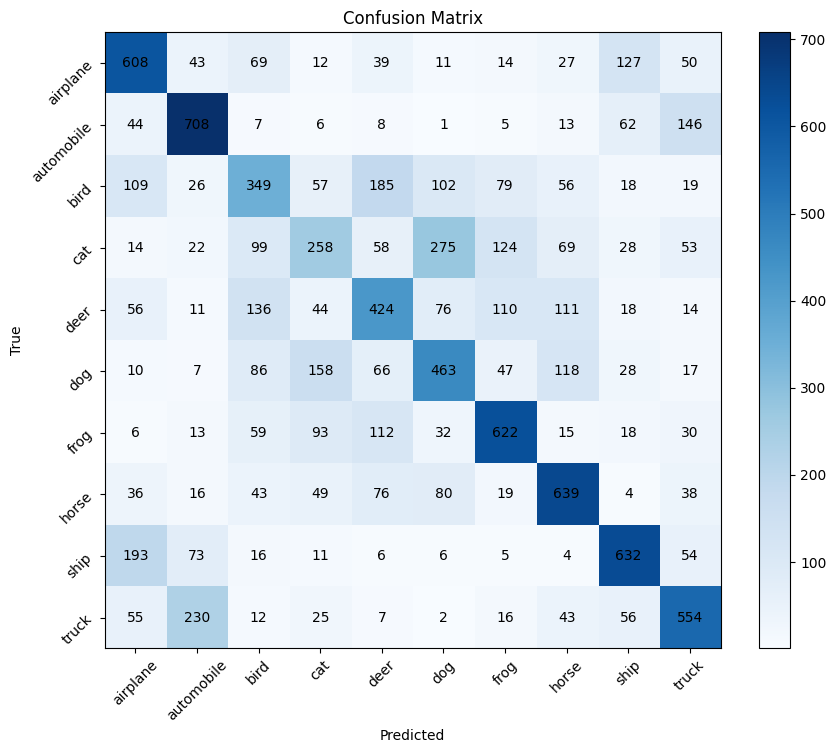

In [29]:
cvt_model = CvT2(image_size=32, in_channels=3, num_classes=10)

print(f"\nTraining")
model = cvt_model.to(device)
train_losses, val_losses, val_accuracies, val_f1_scores = train_model(model, train_loader, val_loader, num_epochs=10)
# plot_metrics(train_losses, val_losses, val_accuracies, val_f1_scores)
print(f"\nTesting")
test_model(model, test_loader)

In [31]:
print(dataset)

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.201))
           )


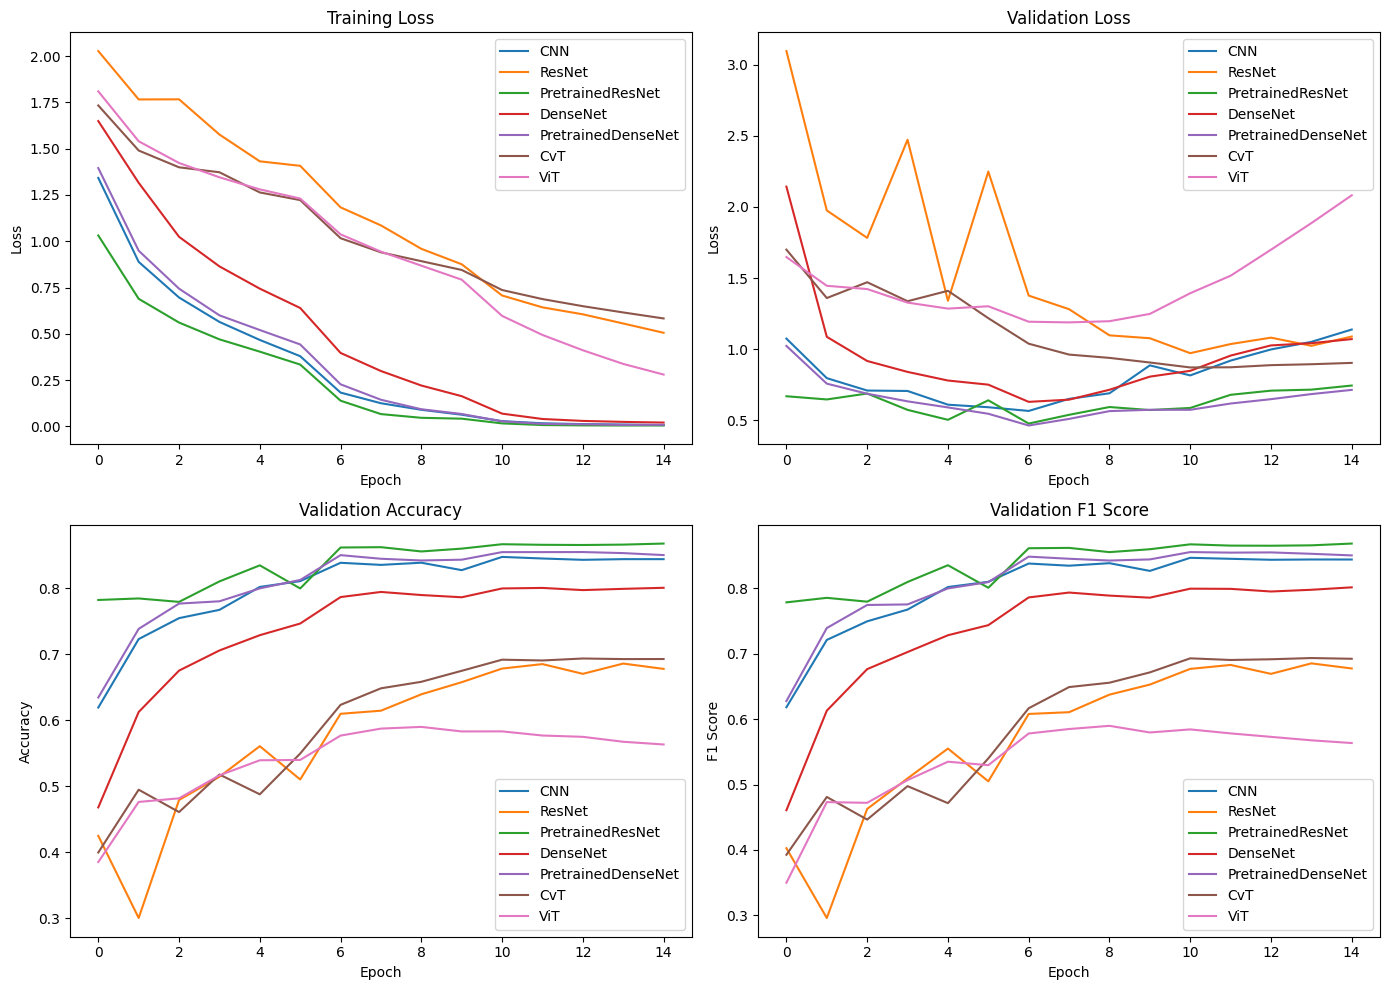

In [34]:
plot_metrics(all_train_losses, all_val_losses, all_val_accuracies, all_val_f1_scores)